In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib_inline
import os
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
import seaborn as sns
from PIL import Image
from numpy import asarray

np.set_printoptions(precision=5)#show 5 number after decimal point 

In [22]:
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.feature_selection import chi2
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import ExtraTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [3]:
url = r"train\\"

In [4]:
def create_data():
    data = list()
    label = 0 #cat = 1 , dog = 0
    for img in tqdm(os.listdir(url)):
        if img.startswith('cat'): label = 1 
        else :label = 0 
        im = asarray(Image.open(url+img).resize((40,40)).convert('L')) #resize and changing colors
        data.append([im,label])
    np.save('data.npy', data)
    return data

In [13]:
data = create_data()

100%|████████████████████████████████████████████████████████████████████████████| 25000/25000 [04:36<00:00, 90.52it/s]


In [5]:
# load the data:
data = np.load('data.npy',allow_pickle=True)

In [6]:
X = (np.array([i[0] for i in data]))
Y = (np.array([i[1] for i in data]))

In [7]:
X = X /255.0

In [8]:
X.shape

(25000, 40, 40)

Text(0.5, 1.0, 'DOG')

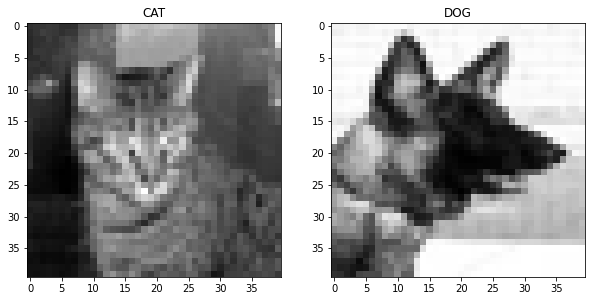

In [9]:
fig = plt.figure(figsize=(10, 7))
  
fig.add_subplot(1, 2, 1)
plt.imshow(X[1,:], cmap=plt.get_cmap('gray'))
plt.title("CAT")

fig.add_subplot(1, 2, 2)
plt.imshow(X[24999,:], cmap=plt.get_cmap('gray'))
plt.title("DOG")

In [10]:
X = X.reshape((25000, 40*40))
X.shape

(25000, 1600)

In [11]:
#split the data to train and test 
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.1, random_state=42)

In [12]:
#split the train
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, test_size=0.1, random_state=42)

In [13]:
# Before we try real models, we will try a dummyClassifier. we will try to get high score than the dummyModel.
dummy_clf = DummyClassifier(strategy="most_frequent", random_state=42)
dummy_clf.fit(X_train, y_train)
y_pred = dummy_clf.predict(X_val)
print("The DummyClassifier score is:" ,round(accuracy_score(y_pred,y_val),2))

The DummyClassifier score is: 0.5


## *Models :*


### *PCA:*

Text(0, 0.5, 'cumulative explained variance')

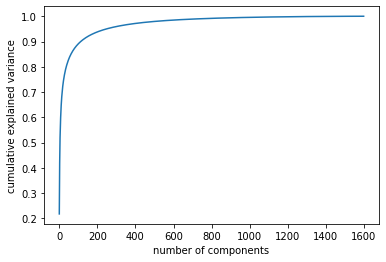

In [14]:
pca = PCA().fit(X_train)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

In [15]:
pca = PCA(n_components = 0.95,random_state=42)
X_reduced_train= pca.fit_transform(X_train)
X_reduced_test = pca.transform(X_val)

In [16]:
X_reduced_train.shape

(20250, 250)

Text(0.5, 1.0, 'After PCA')

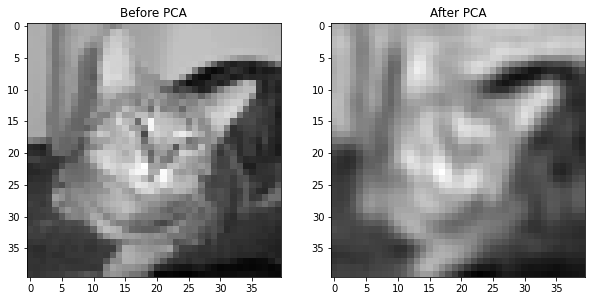

In [17]:
fig = plt.figure(figsize=(10, 7))
X_recovered = pca.inverse_transform(X_reduced_train)
  
fig.add_subplot(1, 2, 1)
plt.imshow(X_train[2,:].reshape(40,40), cmap=plt.get_cmap('gray'))
plt.title("Before PCA")

fig.add_subplot(1, 2, 2)
plt.imshow(X_recovered[2,:].reshape(40,40), cmap=plt.get_cmap('gray'))
plt.title("After PCA")

### *XGBoost with PCA:*

In [25]:
%%time

XGB = XGBClassifier(objective="binary:logistic")
XGB.fit(X_reduced_train, y_train,eval_metric='auc')
y_pred = XGB.predict(X_reduced_test)      
accuracy = metrics.accuracy_score(y_val, y_pred)
print("Accuracy:", round(accuracy,3))

Accuracy: 0.636
CPU times: total: 4min 17s
Wall time: 40.2 s


### *Random Forest with PCA:*

In [26]:
%%time

RFC = RandomForestClassifier(random_state=42)
RFC.fit(X_reduced_train, y_train)
y_predict_RFC = RFC.predict(X_reduced_test)
accuracy = round(metrics.accuracy_score(y_val,y_predict_RFC),3)
print("Accuracy:", accuracy)

Accuracy: 0.612
CPU times: total: 47.4 s
Wall time: 48.3 s


### *VotingClassifier :*

In [18]:
lgb = lgb.LGBMClassifier()
dt_clf = DecisionTreeClassifier()
log_clf = LogisticRegression()
knn_clf = KNeighborsClassifier()
rnd_clf = RandomForestClassifier()
svc  = SVC(kernel='rbf')
nb = GaussianNB()
GBC = GradientBoostingClassifier()
sgd = SGDClassifier(loss='modified_huber')
XGBClassifier = XGBClassifier(objective= 'binary:logistic',eval_metric='auc')

voting_clf = VotingClassifier(estimators=[('lgb', lgb),('GBC',GBC),('nb',nb),('svc', svc),('XGB', XGBClassifier),('rnd',rnd_clf),
                                          ('dt',dt_clf) ,('lr', log_clf), ('knn', knn_clf),('sgd', sgd)
                                          ],voting='hard',n_jobs=-1,)
voting_clf.fit(X_reduced_train, y_train)

VotingClassifier(estimators=[('lgb', LGBMClassifier()),
                             ('GBC', GradientBoostingClassifier()),
                             ('nb', GaussianNB()), ('svc', SVC()),
                             ('XGB',
                              XGBClassifier(base_score=None, booster=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            enable_categorical=False,
                                            eval_metric='auc', gamma=None,
                                            gpu_id=None, importance_type=None,
                                            interaction_constrain...
                                            num_parallel_tree=None,
                                            predictor=None, random_state=None,
                                            reg_alpha=N

In [19]:
for clf in (lgb,GBC, XGBClassifier, rnd_clf,svc , nb,sgd , dt_clf, log_clf, knn_clf, voting_clf):
    clf.fit(X_reduced_train, y_train)
    y_pred = clf.predict(X_reduced_test)
    print(clf.__class__.__name__, round(accuracy_score(y_val, y_pred),3))

LGBMClassifier 0.647
GradientBoostingClassifier 0.632
XGBClassifier 0.636
RandomForestClassifier 0.601
SVC 0.682
GaussianNB 0.562
SGDClassifier 0.514
DecisionTreeClassifier 0.54
LogisticRegression 0.567
KNeighborsClassifier 0.6
VotingClassifier 0.657


### *Feature selection:*

In [12]:
for i in range(400,1700,100):
    X_new = SelectKBest(chi2, k=i).fit_transform(X_train, y_train)
    X_train_new, X_val_new, y_train_new, y_val_new = train_test_split(X_new,y_train, test_size=0.1, random_state=42)
    XGB = XGBClassifier(objective="binary:logistic").fit(X_train_new, y_train_new,eval_metric='auc')
    y_pred = XGB.predict(X_val_new)
    accuracy = round(metrics.accuracy_score(y_val_new, y_pred),3)
    print("number of features : ", i, ", Accuracy:", accuracy)

number of features :  400 , Accuracy: 0.611
number of features :  500 , Accuracy: 0.621
number of features :  600 , Accuracy: 0.64
number of features :  700 , Accuracy: 0.655
number of features :  800 , Accuracy: 0.663
number of features :  900 , Accuracy: 0.664
number of features :  1000 , Accuracy: 0.66
number of features :  1100 , Accuracy: 0.652
number of features :  1200 , Accuracy: 0.67
number of features :  1300 , Accuracy: 0.658
number of features :  1400 , Accuracy: 0.668
number of features :  1500 , Accuracy: 0.669
number of features :  1600 , Accuracy: 0.662


> best accuracy with 1200 features

In [20]:
selector = SelectKBest(chi2, k=1225)
X_train = selector.fit_transform(X_train,y_train)
X_val =selector.transform(X_val)

### *KMeans :*

In [23]:
pipeline = Pipeline([
 ("kmeans", KMeans(n_clusters=20)),
 ("XGB", XGBClassifier(objective="binary:logistic",eval_metric='auc'))])

pipeline.fit(X_train, y_train)
y_predict_pipe = pipeline.predict(X_val)
round(metrics.accuracy_score(y_val,y_predict_pipe),3)

0.561

In [24]:
pipeline = Pipeline([
 ("kmeans", KMeans(n_clusters=20)),
 ("Random Forest", RandomForestClassifier(random_state=42))])

pipeline.fit(X_train, y_train)
y_predict_pipe = pipeline.predict(X_val)
round(metrics.accuracy_score(y_val,y_predict_pipe),3)

0.573

### *Random Forest Classifier :*

In [25]:
%%time

RF = RandomForestClassifier(random_state=42)
RF.fit(X_train, y_train)
y_pred_RF = RF.predict(X_val)
accuracy = round(metrics.accuracy_score(y_val,y_pred_RF),3)
print("Accuracy:", accuracy)

Accuracy: 0.656
CPU times: total: 1min 5s
Wall time: 1min 6s


### *XGB Classifier:*

In [26]:
%%time

XGBoost = XGBClassifier(objective="binary:logistic", random_state=42)
XGBoost.fit(X_train, y_train, eval_metric='auc')
y_pred_XGB = XGBoost.predict(X_val)

accuracy = round(metrics.accuracy_score(y_val, y_pred_XGB),3)
print("Accuracy:", accuracy)

Accuracy: 0.66
CPU times: total: 4min 15s
Wall time: 39 s


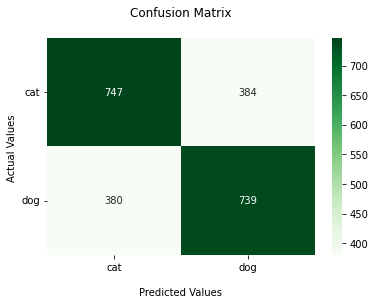

In [27]:
cf_matrix = confusion_matrix(y_val, y_pred_XGB)
fig, ax = plt.subplots(figsize=(6,4))
ax = sns.heatmap(cf_matrix, annot=True, fmt='', cmap='Greens')
ax.set_title('Confusion Matrix\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
ax.xaxis.set_ticklabels(["cat","dog"])
ax.yaxis.set_ticklabels(["cat","dog"],rotation=0)

plt.show()

### *AdaBoost Classifier:*

In [28]:
%%time

AdB =  AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), n_estimators=200,
                          algorithm="SAMME.R", learning_rate=0.5)
AdB.fit(X_train, y_train)
y_pred = AdB.predict(X_val)

accuracy = round(metrics.accuracy_score(y_val, y_pred),3)
print("Accuracy:", accuracy)

Accuracy: 0.615
CPU times: total: 5min 38s
Wall time: 5min 39s


### *SVC:*

In [29]:
svc  = SVC(kernel='rbf')
svc.fit(X_train, y_train)
y_pred = svc.predict(X_val)

accuracy = round(metrics.accuracy_score(y_val, y_pred),3)
print("Accuracy:", accuracy)

Accuracy: 0.673


### *Gradient Boosting Classifier:*

In [30]:
GBC = GradientBoostingClassifier(verbose=1).fit(X_train, y_train)
y_pred = GBC.predict(X_val)

accuracy = round(metrics.accuracy_score(y_val, y_pred),3)
print("Accuracy:", accuracy)  

      Iter       Train Loss   Remaining Time 
         1           1.3794            7.76m
         2           1.3731            7.67m
         3           1.3675            7.82m
         4           1.3624            7.83m
         5           1.3580            7.62m
         6           1.3535            7.45m
         7           1.3488            7.26m
         8           1.3452            7.15m
         9           1.3414            7.06m
        10           1.3371            6.93m
        20           1.3068            6.06m
        30           1.2841            5.33m
        40           1.2670            4.56m
        50           1.2505            3.83m
        60           1.2367            3.08m
        70           1.2226            2.32m
        80           1.2086            1.54m
        90           1.1967           45.84s
       100           1.1860            0.00s
Accuracy: 0.656


### Hyperparameter Tuning: 

In [ ]:
#Searching for better performance out of the models with RandomizedSearch

In [31]:
param = {'C': [1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01],
              'kernel': ['rbf']}
 
random_SVC = RandomizedSearchCV(SVC(), param, verbose = 3, cv=3,n_iter=3)

random_SVC.fit(X_train, y_train)
y_pred_SVC_random = random_SVC.predict(X_val)
print ("Accuracy Score = ",round(metrics.accuracy_score(y_val,y_pred_SVC_random),3))

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV 1/3] END .......C=10, gamma=0.1, kernel=rbf;, score=0.620 total time= 8.6min
[CV 2/3] END .......C=10, gamma=0.1, kernel=rbf;, score=0.614 total time= 5.5min
[CV 3/3] END .......C=10, gamma=0.1, kernel=rbf;, score=0.619 total time= 9.5min
[CV 1/3] END ........C=1, gamma=0.1, kernel=rbf;, score=0.605 total time= 9.0min
[CV 2/3] END ........C=1, gamma=0.1, kernel=rbf;, score=0.604 total time= 8.5min
[CV 3/3] END ........C=1, gamma=0.1, kernel=rbf;, score=0.606 total time= 9.1min
[CV 1/3] END .......C=1, gamma=0.01, kernel=rbf;, score=0.647 total time= 3.0min
[CV 2/3] END .......C=1, gamma=0.01, kernel=rbf;, score=0.635 total time= 2.5min
[CV 3/3] END .......C=1, gamma=0.01, kernel=rbf;, score=0.650 total time= 3.7min
Accuracy Score =  0.668


In [ ]:
random_SVC.

### Testing the final models
- XGB
- Voting Classifier
- SVC

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.1, random_state=42)

In [33]:
selector = SelectKBest(chi2, k=1225)
X_train = selector.fit_transform(X_train,y_train)
X_test =selector.transform(X_test)

In [17]:
%%time

XGB = XGBClassifier(objective="binary:logistic",random_state=42)
XGB.fit(X_train, y_train,eval_metric='auc')
y_pred = XGB.predict(X_test)
accuracy = metrics.accuracy_score(y_test, y_pred)
print("Accuracy:", round(accuracy,3))

Accuracy: 0.671
CPU times: total: 5min 39s
Wall time: 1min


In [ ]:
%%time
voting_clf = VotingClassifier(estimators=[('lgb', lgb),('GBC',GBC),('nb',nb),('svc', svc),('XGB', XGBClassifier)
                                          ,('rnd',rnd_clf),('dt',dt_clf) ,('lr', log_clf), ('knn', knn_clf),('sgd', sgd)
                                          ],voting='hard',n_jobs=-1,)
voting_clf.fit(X_train, y_train)
y_pred = voting_clf.predict(X_test)
accuracy = metrics.accuracy_score(y_test, y_pred)
print("Accuracy:", round(accuracy,3))

In [34]:
%%time

svc  = SVC(kernel='rbf')
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)

accuracy = round(metrics.accuracy_score(y_test, y_pred),3)
print("Accuracy:", accuracy)

Accuracy: 0.648
CPU times: total: 14min 27s
Wall time: 14min 31s


## *Best  accuracy : 0.67*